In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
pd.set_option('display.max_columns', None)
import filter_function as ff


In [2]:
#Loading the dataset

df=pd.read_excel('SharkAttack.xlsx')
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-02-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Blasck Wall Reach Swan River Perth,Kayaking,Georgina Smith,F,35,None kayak badly damaged by shark,N,0815hrs,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-22 00:00:00,2025.0,Questionable,Australia,NSW,Off Port Stephens near Newcastle,Fishing was pulled of boat by shark,Paul Barning,M,58,Body not recovered,Y,1300hrs,Mako shark,Simon De Marchi: Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-02-22 00:00:00,2025.0,Unprovoked,Australia,Queensland,The Wrecks walking track Moreton Island,Snorkeling,Unknown Male,M,29,Abdominal and leg injuries,N,1503hrs,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-02-10 00:00:00,2025.0,Unprovoked,Bahamas,NaN,Bimini Bay,Swimming,Summer Layman,F,24,Left foot injured,N,1830hrs,bull shark,Dail Mail Australia Todd Smith: Kevin McMurray...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-02-10 00:00:00,2025.0,Unprovoked,Bahamas,NaN,Bimini Bay,Swimming,Rileigh Decker,F,20,Severed archilles tendon artery severed nerves...,N,1830hrs,bull shark,Dail Mail Australia Todd Smith: Kevin McMurray...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(7004, 23)

In [4]:
#Cleaning the column Fatal 
df["Fatal Y/N"] = df["Fatal Y/N"].str.strip()
df["Fatal Y/N"] = df["Fatal Y/N"].str.lower()
df["Fatal Y/N"] = df["Fatal Y/N"].replace({"f": "y", "m": "y", "nan": "n", "nq": "n", "unknown": "unknown", "y x 2": "y"})
df["Fatal Y/N"] = df["Fatal Y/N"].fillna("unknown")

df['Fatal Y/N'].unique()

array(['n', 'y', 'unknown'], dtype=object)

In [5]:
#Counting the Fatal, Non-Fatal,Unknown incidents
fatal_counts=df['Fatal Y/N'].value_counts()
print(fatal_counts)


Fatal Y/N
n          4887
y          1484
unknown     633
Name: count, dtype: int64


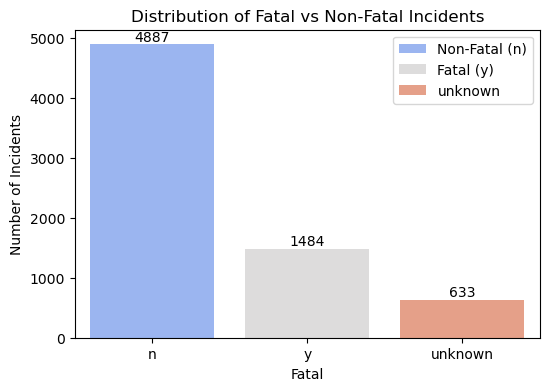

In [6]:
#Visualizing the Fatal column

# Plot the distribution of fatal incidents
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Fatal Y/N', hue='Fatal Y/N', palette='coolwarm', legend=False)
ax.legend( loc='upper right', labels=['Non-Fatal (n)', 'Fatal (y)','unknown'])

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Distribution of Fatal vs Non-Fatal Incidents')
plt.xlabel('Fatal')
plt.ylabel('Number of Incidents')
plt.show()

In [7]:
#Cleaning the Activity column

df['Activity']=df['Activity'].fillna('unknown') #Filling missing values
df['Activity']=df['Activity'].str.lower().str.strip() #Standardizing the text

# Applyinbg the categorization function
df['Activity'] = df['Activity'].apply(ff.categorize_activity)

# Verifying the results
print(df['Activity'].value_counts())

# Save the cleaned dataset
#df.to_excel('cleaned_shark_attacks.xlsx', index=False)


Activity
swimming            1863
surfing             1634
fishing             1272
other activities     698
diving               673
unknown              589
watercraft           275
Name: count, dtype: int64


In [8]:
#Visualizing the activity counts
activity_proportions = df['Activity'].value_counts(normalize=True) * 100
print(activity_proportions)


Activity
swimming            26.599086
surfing             23.329526
fishing             18.161051
other activities     9.965734
diving               9.608795
unknown              8.409480
watercraft           3.926328
Name: proportion, dtype: float64


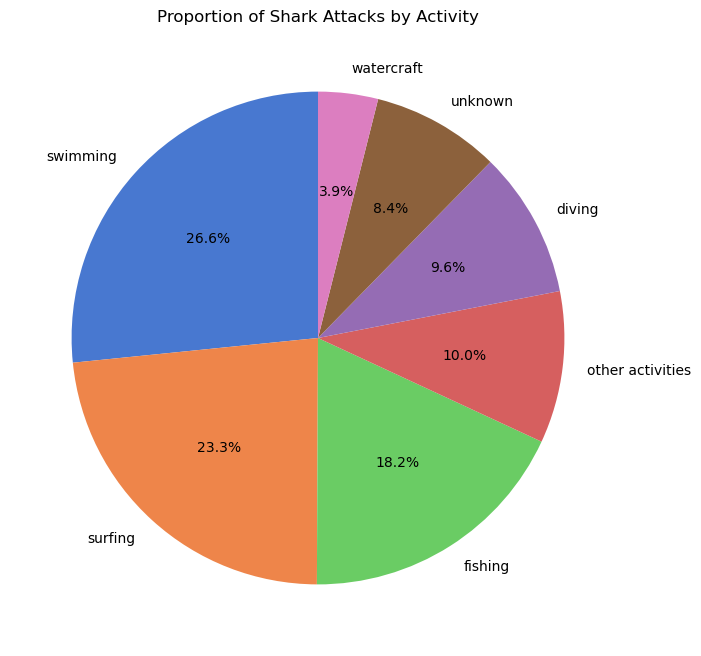

In [9]:
# Plot the distribution of activities (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(activity_proportions, labels=activity_proportions.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'))
plt.title('Proportion of Shark Attacks by Activity')
plt.show()

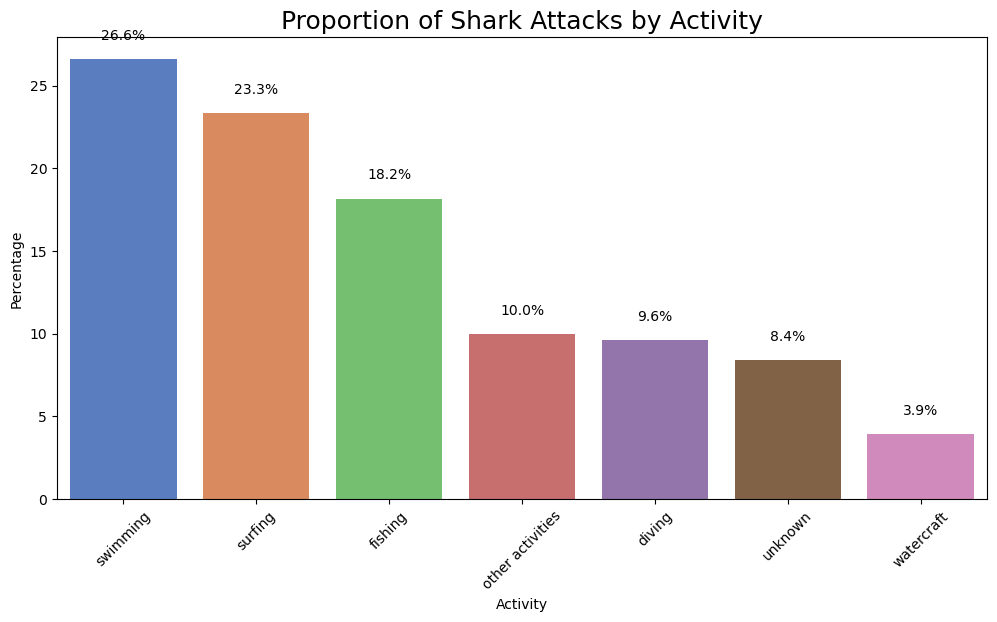

In [10]:
# Plot the distribution of activities (Bar Plot)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=activity_proportions.index, y=activity_proportions.values, hue=activity_proportions.index, palette='muted', legend=False)

# Add annotations
for i, proportion in enumerate(activity_proportions):
    ax.text(i, proportion + 1, f'{proportion:.1f}%', ha='center', va='bottom')

plt.title('Proportion of Shark Attacks by Activity', fontsize=18)
plt.xlabel('Activity')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

In [11]:
#The relationship of between activities and fatal incidents
activity_fatal = pd.crosstab(df['Activity'], df['Fatal Y/N'])
activity_fatal

Fatal Y/N,n,unknown,y
Activity,,,
diving,464,69,140
fishing,1016,80,176
other activities,374,75,249
surfing,1438,65,131
swimming,1138,150,575
unknown,312,166,111
watercraft,145,28,102


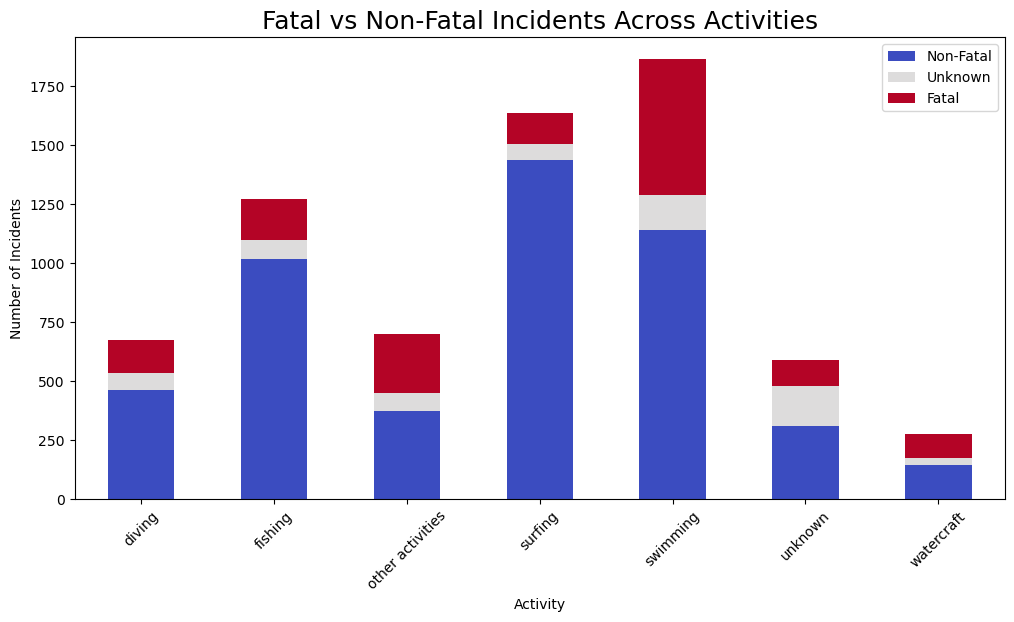

In [12]:
# Plot the relationship (Stacked Bar Plot)
activity_fatal.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Fatal vs Non-Fatal Incidents Across Activities', fontsize=18)

plt.xlabel('Activity')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(loc='upper right',labels=['Non-Fatal', 'Unknown', 'Fatal', ])

plt.show()

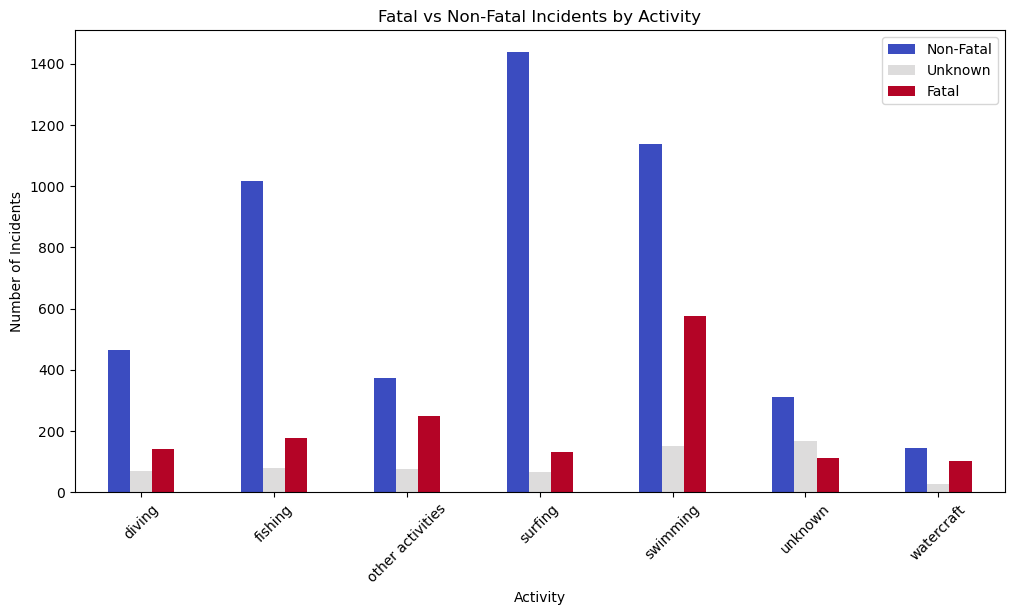

In [13]:
# Plot the relationship (Grouped Bar Plot)
activity_fatal.plot(kind='bar', figsize=(12, 6), colormap='coolwarm')  
plt.title('Fatal vs Non-Fatal Incidents by Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend( loc='upper right', labels=['Non-Fatal','Unknown','Fatal'])
plt.show()

In [14]:
#Conduct a Chi-square test to determine if the fatal incidents distribution is independent of the activites.
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(activity_fatal)

chi2_statistic, chi2_p_value

print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {chi2_p_value}")

Chi-square Statistic: 831.8081181485189
P-value: 2.4899270379626e-170


In [15]:
# Computing the association between variables in 'activity_fatal' using the "cramer" method
cramer_method = association(activity_fatal, method="cramer")

print(f"Cramér's V: {cramer_method}")

Cramér's V: 0.24368203384732431


In [16]:
#Statistically significant result: There is evidence to suggest that the occurrence of fatal shark incidents 
# -is not independent of the activity people were engaged in at the time of the attack.
#Weak-to-moderate association: The strength of the relationship between activities and fatal incidents is weak to moderate, 
# meaning certain activities (like swimming and other activities) show a higher association with fatal shark attacks compared to others.

In [17]:
df["Year"] = df["Year"].fillna(0).astype(int)
df["Year"].value_counts()
# create month from Date - by Sergej
df['Date'] = df['Date'].astype(str)
df.insert(2, "month",df['Date'].apply(lambda x: ff.extract_month(x)))
# create season from month - by Sergej
df.insert(3, "season",df['month'].apply(lambda x:ff.month_to_season(x)))

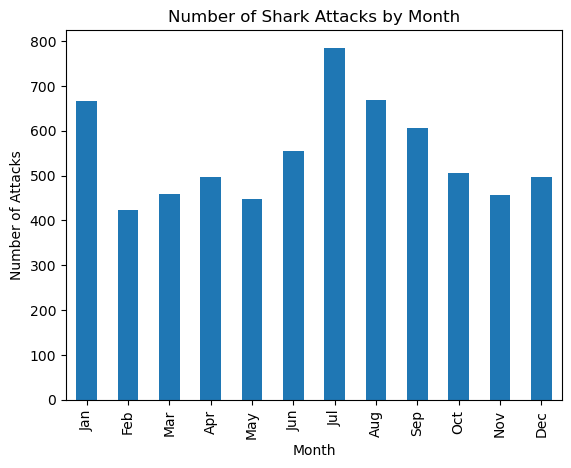

In [18]:
monthly_attacks = df[((df["month"] < 13) & (df["month"] > 0))].groupby('month').size()
# Plotting the graph
monthly_attacks.plot(kind='bar', ) # bar chart
plt.title('Number of Shark Attacks by Month')
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # X-axis labels
plt.show()